In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

# Single scan, WITH TT correction

In [2]:
pgroup='p20537'
runnumber = 164

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0164


'/sf/alvra/data/p20537/raw/run0164-FePhen_timescan_7119p5eV/meta/scan.json'

In [3]:
quantile_corr = 0.4

channel_delay_motor = channel_delay_topas
Timezero_mm = 199.37992 ## 

detector_XAS = "SARES11-GES1:CH1_VAL_GET"
detector_Izero = channel_Izero110

TT = TT_PSEN126

reducedir='/das/work/p20/p20537/Claudio/Reduced_XANES_timescans_TT/'
saveflag=True

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
flag = False

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:
    Timezero_mm = Timezero_mm
            
(Delays_fs_scan, Delays_corr_scan, DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, Pump_probe_scan,
    Izero_pump_scan, Izero_unpump_scan, correlation, readbacks, goodshots) = \
    XAS_scanPP_PSEN_bs(scan, TT, channel_delay_motor, detector_XAS, detector_Izero, Timezero_mm, quantile_corr)#, target, px2fs)

if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))
    
Delay_mm, Delay_fs = adjust_delayaxis(scan,readbacks,Timezero_mm)

if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_data_timescans_TT(reducedir, run_name, Delays_fs_scan, Delays_corr_scan,
                            DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, Pump_probe_scan, goodshots)


Processing: run0164-FePhen_timescan_7119p5eV
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET                 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                 997 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 997 / 1001 -> 0% loss
complete channels: 9 / 10 -> 10% incompl

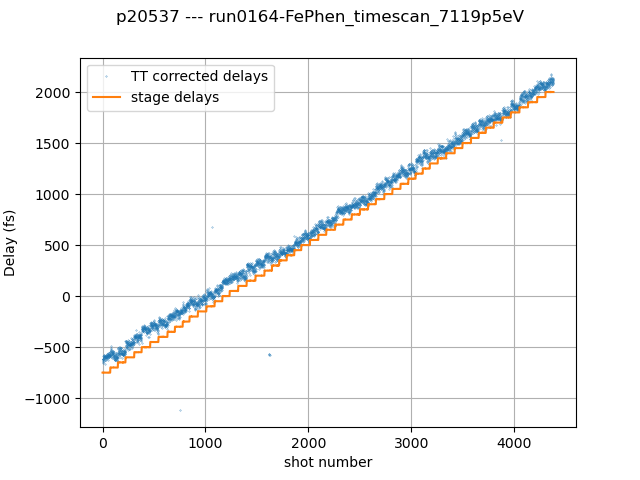

In [4]:
plt.figure()
plt.suptitle(titlestring)
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

## Choose variable binsize...

In [166]:
numbins = 500

#####################################################################################################
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin),
                     np.arange(npt),
                     np.sort(x))

binList = histedges_equalN(Delays_corr_scan, numbins)

bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.copy(bin_centres)

## ... or a fix binsize with a range

In [175]:
binsize = 25 # in fs

min_delay = -700
max_delay = 2200

#####################################################################################################

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

In [176]:
noTT = False

############################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan))

if noTT:
    binList = np.copy(Delay_fs)
    bin_centres = (binList[:-1] + binList[1:])/2
    pp_TT, binEdges, binNumber = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='mean', bins=binList)
    Delay_fs_TT = bin_centres
else:
    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)

(6925,) (6925,)


In [5]:
binsize = 25 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan))

binList = np.arange(Delays_fs_scan[0] - 100, Delays_fs_scan[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan[0] - 100 + binsize/2, Delays_fs_scan[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)

(4382,) (4382,)


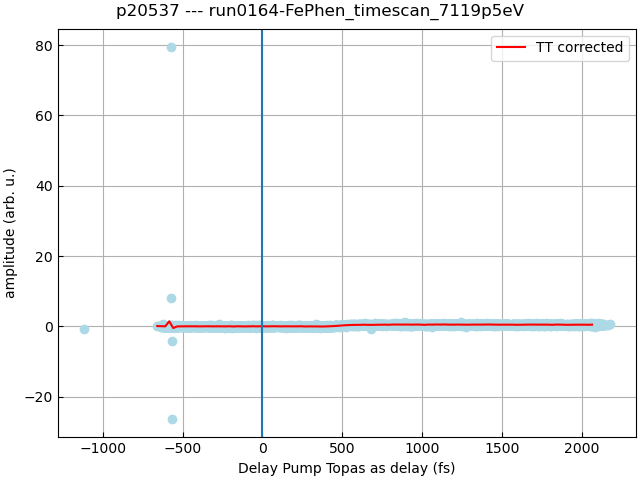

In [6]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
#plt.plot(Delay_fs_TT, pp_fit)

#boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
#                     r't0_TT = {} mm'.format(np.round(timezero_mm + fs2mm(t0_fs,0),5)),
#            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
#plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.axvline(0)

plt.show()


#print("Position t0_raw = {} mm".format(Timezero_mm ))
#print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

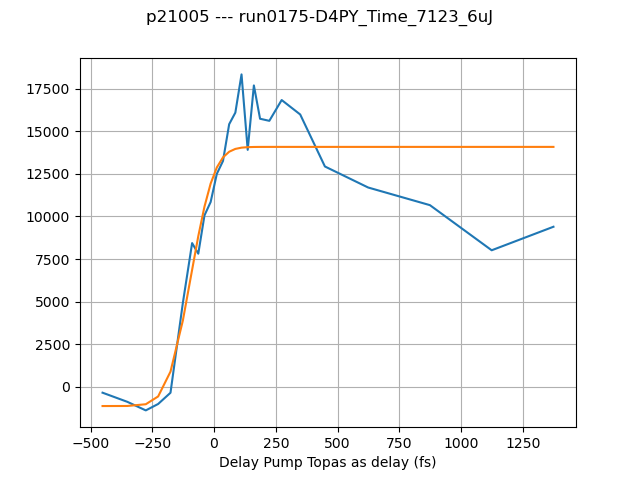

t0 = -93.58774742796744 fs
width = 175.01649311124032 fs (FWHM)


In [147]:
fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)

index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
t0_mm = fit.popt[0]
width_fs = fit.popt[2]

plt.figure()
plt.suptitle(titlestring)
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, pp_fit)
plt.xlabel("{} ({})".format(label, units))
plt.grid()
plt.show()

print ('t0 = {} fs'.format(t0_mm))
print ('width = {} fs (FWHM)'.format(abs(width_fs)))

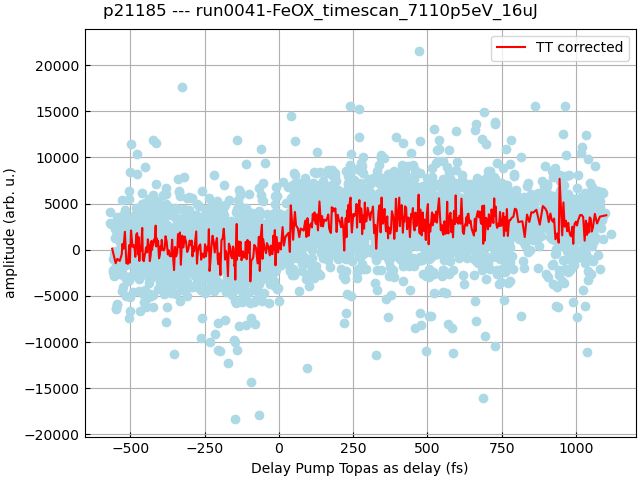

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
#plt.plot(Delay_fs_TT, pp_fit)

#boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
#                     r't0_TT = {} mm'.format(np.round(timezero_mm + fs2mm(t0_fs,0),5)),
#            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
#plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

#print("Position t0_raw = {} mm".format(Timezero_mm ))
#print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

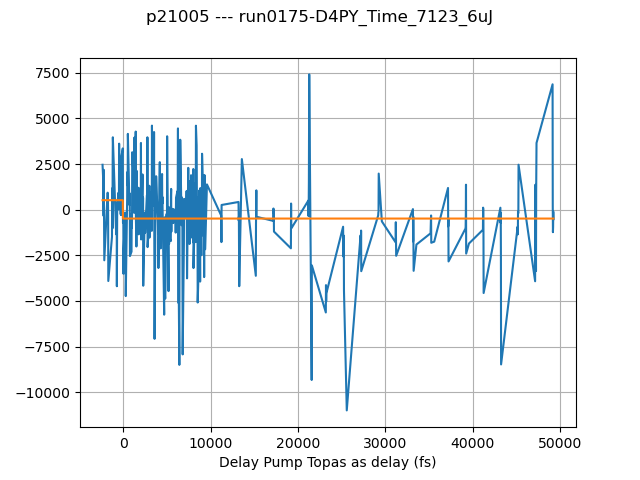

t0 = -57.39059565823961 fs
width = 0.5374416008020209 fs (FWHM)


Position t0 = 432.5112 from 199.3799 mm
Width = -141.5998 fs


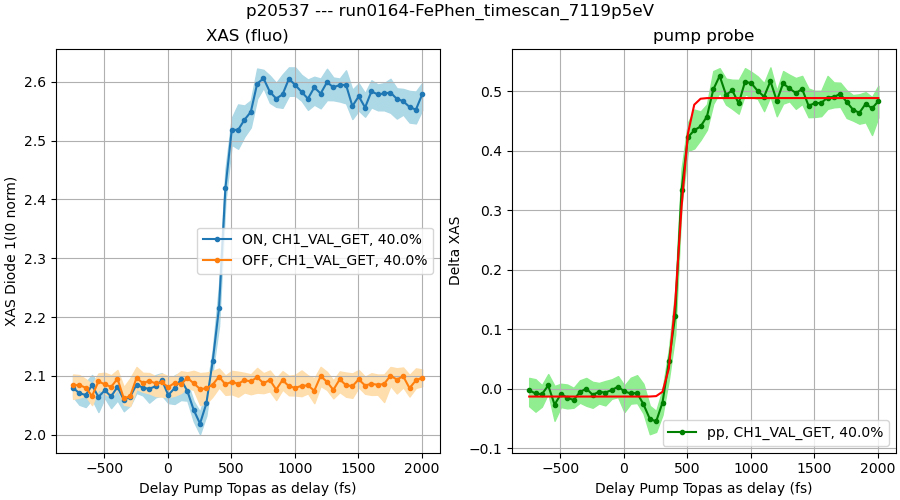

In [7]:
fitflag = True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)
units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(Delay_fs, XAS_pump, label='ON, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS_unpump, label='OFF, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_unpump, err_high_unpump, color='navajowhite')

ax2.plot(Delay_fs, XAS_pump_probe, label='pp, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(Delay_fs, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

if fitflag:
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    fit.estimate(Delay_fs, XAS_pump_probe)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs,XAS_pump_probe)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting
    t0_mm = fit.popt[0]
    width_fs = fit.popt[2]
    ax2.plot(Delay_fs, pp_fit, color='red')
    print("Position t0 = {:.4f} from {:.4f} mm".format(t0_mm, Timezero_mm))
    print("Width = {:.4f} fs".format(width_fs))

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

## Check correlation for a certain delay point

In [7]:
chosen_delay_fs = 1000

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, correlation_filter = \
Get_correlation_from_scan2(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

arrays_to_filter = ["Fluo_pump", "Fluo_unpump", "Izero_pump", "Izero_unpump"]
arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, globals_dict=globals())

# (Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
#  Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
# Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))
print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

Correlation (all shots)      = 0.9944436248954032
Correlation (filtered shots) = 0.998980814069482
Delay = 1003.34 fs


In [8]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 2.5952737298914954, Median (filtered) = 2.5956578917087567
MAD (all) = 0.1229613054362503, MAD(filtered) = 0.07360833957785952
MAD/median (all) = 4.737893503102316%, MAD/median (filtered) = 2.8358259311824083%


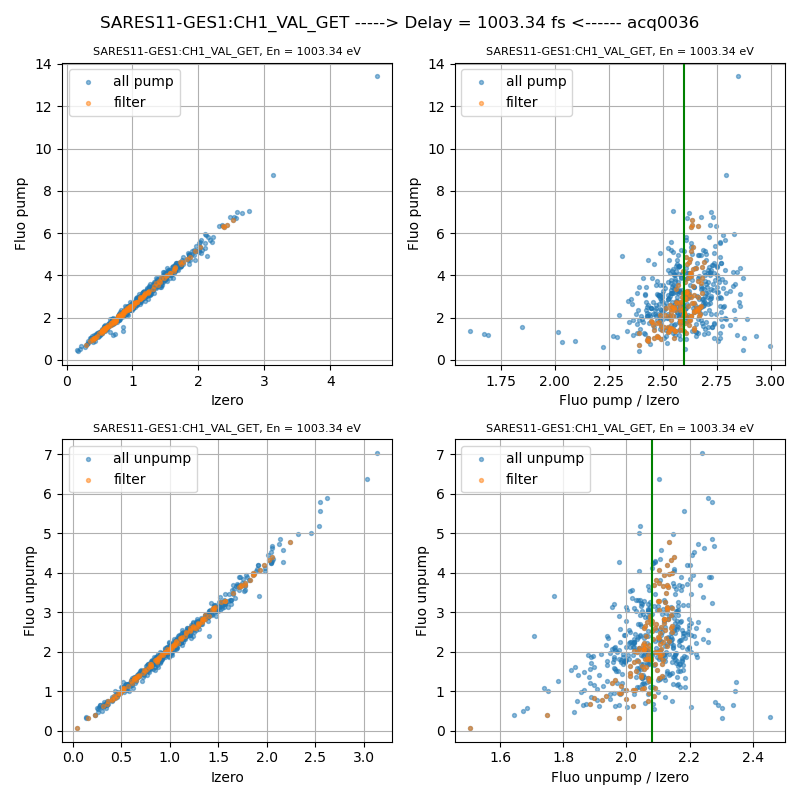

In [12]:
#chosen_delay_fs = 1000

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

quantile_corr = 0.5
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

#index_delay = np.arange(len(Delay_fs))[(chosen_delay_fs > chosen_delay_fs)][0]
index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, correlation_filter = \
Get_correlation_from_scan2(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

arrays_to_filter = ["Fluo_pump", "Fluo_unpump", "Izero_pump", "Izero_unpump"]
arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, globals_dict=globals())

# (Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
#  Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
# Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

#print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
#print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))

#print ('delay = {} fs'.format(index_delay[index_energy]))

fig,ax = plt.subplots(2,2,figsize=(8,8))
plt.suptitle('{} -----> Delay = {:.2f} fs <------ {}'.format(detector_XAS,Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))

ax[0][0].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Delay_fs[index_delay]),fontsize=8)
ax[0][0].scatter(Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all pump')
ax[0][0].scatter(Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel('Izero')
ax[0][0].set_ylabel('Fluo pump')
ax[0][0].grid()

m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)

ax[0][1].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Delay_fs[index_delay]),fontsize=8)
ax[0][1].scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all pump')
ax[0][1].scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel('Fluo pump / Izero')
ax[0][1].set_ylabel('Fluo pump')
ax[0][1].axvline(x=m_median_filter, color = 'green')
ax[0][1].grid()

ax[1][0].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Delay_fs[index_delay]),fontsize=8)
ax[1][0].scatter(Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all unpump')
ax[1][0].scatter(Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel('Izero')
ax[1][0].set_ylabel('Fluo unpump')
ax[1][0].grid()

m_median_filter = np.median(Fluo_unpump_filter/Izero_unpump_filter)

ax[1][1].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Delay_fs[index_delay]),fontsize=8)
ax[1][1].scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all unpump')
ax[1][1].scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel('Fluo unpump / Izero')
ax[1][1].set_ylabel('Fluo unpump')
ax[1][1].axvline(x=m_median_filter, color = 'green')
ax[1][1].grid()


plt.tight_layout()

(4409,)

# Loop of scans, WITH TT correction

In [1]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p20537/raw/*FePhen_timescan_7119p5eV*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:]
patch

NameError: name 'glob' is not defined

In [36]:
quantile_corr = 0.4

channel_delay_motor = channel_delay_topas
Timezero_mm = 199.37992 ## 

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

TT = TT_PSEN126
#########################################################
from sfdata import SFScanInfo

Pump_probe_all = []
Delay_fs_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    flag = False

    try:
        flag = True
        Timezero_mm = get_timezero_NBS(json_file)
    except:
        Timezero_mm = Timezero_mm
        
    (Delays_fs_scan, Delays_corr_scan, DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, Pump_probe_scan,
    Izero_pump_scan, Izero_unpump_scan, correlation, readbacks, goodshots) = \
    XAS_scanPP_PSEN_bs(scan, TT, channel_delay_motor, detector_XAS, detector_Izero, Timezero_mm, quantile_corr)#, target, px2fs)
    
    Pump_probe_all.extend(Pump_probe_scan)
    Delay_fs_all.extend(Delays_corr_scan)

    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))
        
    Delay_mm, Delay_fs = adjust_delayaxis(scan,readbacks,Timezero_mm)

Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)

Processing: run0175-FePhen_timescan_7119p5eV_010
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET                 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                 998 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 998 / 1001 -> 0% loss
complete channels: 9 / 10 -> 10% inc

In [16]:
binsize = 10 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_all),np.shape(Delay_fs_all))

binList = np.arange(Delays_fs_scan[0] - 300, Delays_fs_scan[-1] + 300, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan[0] - 300 + binsize/2, Delays_fs_scan[-1] + 300 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delay_fs_all, Pump_probe_all, statistic='mean', bins=binList)

(48879,) (48879,)


NameError: name 'patch' is not defined

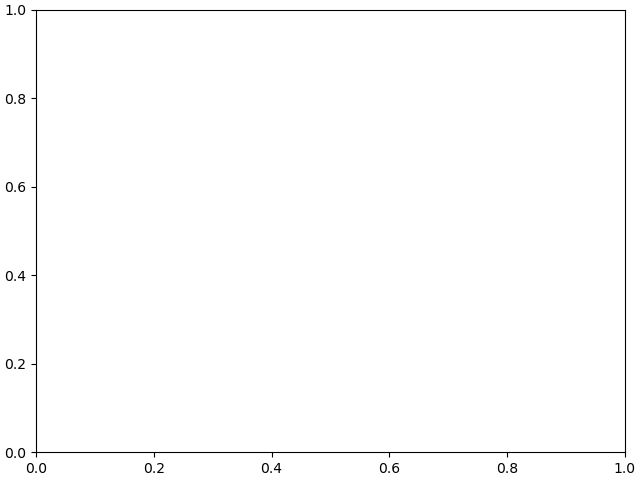

In [34]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(f'{len(patch)} scans from loop')

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
#plt.plot(Delay_fs_TT, pp_fit)

#boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
#                     r't0_TT = {} mm'.format(np.round(timezero_mm + fs2mm(t0_fs,0),5)),
#            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
#plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

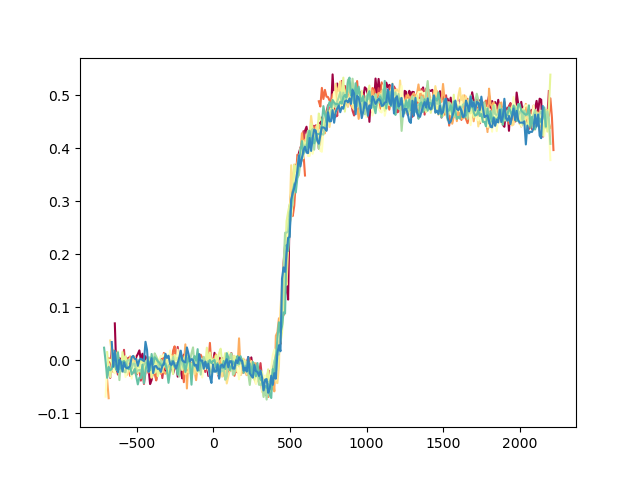

In [99]:

idx = np.concatenate(([0], np.where(np.diff(Delay_fs_all)<-1000)[0]), axis=0)
binList = np.arange(Delays_fs_scan[0] - 300, Delays_fs_scan[-1] + 300, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan[0] - 300 + binsize/2, Delays_fs_scan[-1] + 300 - binsize/2, binsize)

fig, ax = plt.subplots()
ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,11)))

for i in range(len(idx)-1):
    Delay_fs_test = Delay_fs_all[idx[i]:idx[i+1]]
    Pump_probe_test = Pump_probe_all[idx[i]:idx[i+1]]
    pp_TT_test, binEdges_test, binNumber_test = binned_statistic(Delay_fs_test, Pump_probe_test, statistic='mean', bins=binList)
    
    ax.plot(Delay_fs_TT, pp_TT_test, label = 'TT corrected')
# plt.plot(test[idx] )
plt.show()

In [94]:
idx

array([    0,  4450,  8818, 13303, 17772, 22154, 26614, 31023, 35428,
       39906, 44389])